In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import datediff, col, lag, avg
from pyspark.sql.window import Window

In [2]:
sp = SparkSession.builder.appName("prelim analysis").config("spark.sql.session.timeZone", "+10").getOrCreate()
sp

22/09/26 12:19:29 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.17.231.204 instead (on interface eth0)
22/09/26 12:19:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/26 12:19:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read all transactions together
from functools import reduce

dir = "../data/tables/"
groups = ["transactions_20210228_20210827_snapshot/", "transactions_20210828_20220227_snapshot/", "transactions_20220228_20220828_snapshot/"]
final_list = []

for g in groups:
    final_list.append(sp.read.parquet(dir + g))

trans = reduce(DataFrame.unionAll, final_list)
trans.show(4)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 4 rows



# Initial analysis on transactions

### Checking Dollar values by date

In [7]:
amount_per_day = trans.groupBy("order_datetime").sum("dollar_value").toPandas()
amount_per_day.head()

,order_datetime,sum(dollar_value)
0,2021-08-27,3.860810e+06
1,2021-07-30,3.714503e+06
2,2021-07-23,3.824223e+06
3,2021-08-21,4.235846e+06
4,2021-05-21,3.677561e+06


In [18]:
amount_per_day.columns = ["order dates", "transaction amount"]
amount_per_day["order dates"] = pd.to_datetime(amount_per_day["order dates"])
amount_per_day.sort_values(by="order dates", inplace=True)

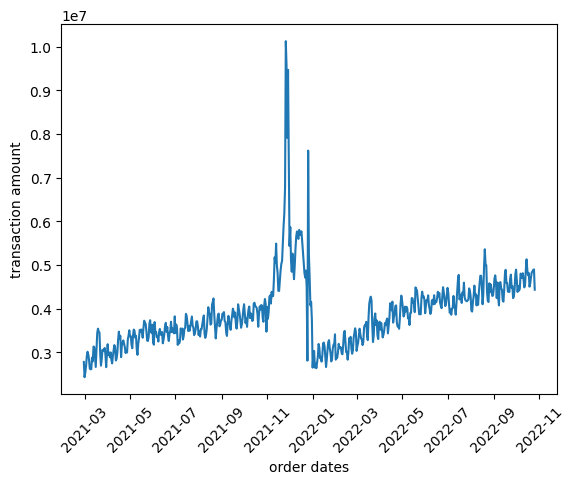

In [19]:
sns.lineplot(x="order dates", y="transaction amount", data=amount_per_day)
plt.xticks(rotation=45)
plt.show()

In [22]:
# Checking date limits
amount_per_day[amount_per_day["order dates"] > "2022-08-28"].count()

order dates           59
transaction amount    59
dtype: int64

We find that there are 59 transactions beyond the given date range. But that is fine as it simply adds to more relevant data.

Let's check the pattern seen in the above pattern more closely

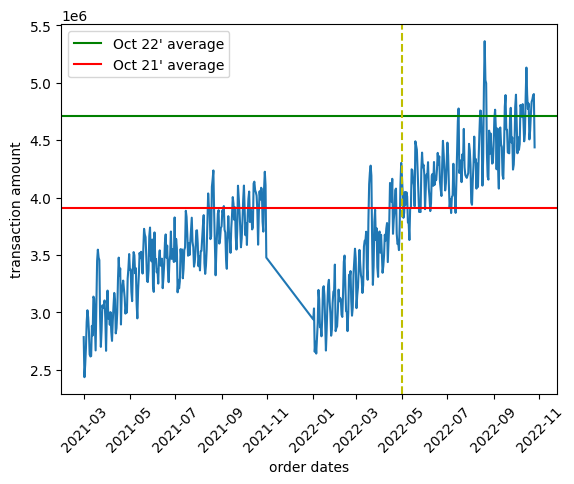

In [46]:
pattern_check = amount_per_day[(amount_per_day["order dates"] < "11-1-2021") | (amount_per_day["order dates"] >"1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=pattern_check)

oct_2011_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2021") & (amount_per_day["order dates"] < "11-1-2021")]["transaction amount"].mean()
oct_2022_avg = amount_per_day[(amount_per_day["order dates"] >= "10-1-2022") & (amount_per_day["order dates"] < "11-1-2022")]["transaction amount"].mean()

plt.axhline(oct_2022_avg, color='g', label="Oct 22' average")
plt.axhline(oct_2011_avg, color='r', label="Oct 21' average")

plt.axvline(pd.to_datetime("5-1-2022"), color='y', linestyle="--")

plt.legend()

plt.xticks(rotation=45)
plt.show()

As seen in the graph, over the years of 21 and 22, there have been significant growth and fast paced recovery (considering a COVID effect on real-world like application). It is also important to note that there is a significant pattern in terms of purchasing power of customers. More of a deep dive is required to understand why it is an incresing trend every year rather than an overall increasing/linear trend

#### Special analysis of holiday season

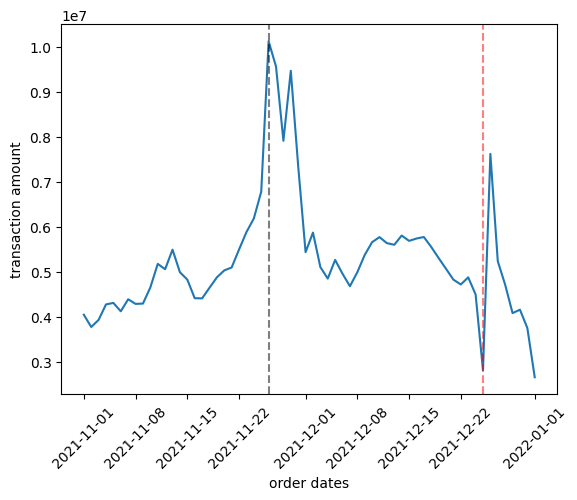

In [50]:
holiday_check = amount_per_day[(amount_per_day["order dates"] >= "11-1-2021") & (amount_per_day["order dates"] <= "1-1-2022")]

sns.lineplot(x="order dates", y="transaction amount", data=holiday_check)

plt.axvline(pd.to_datetime("12-25-2021"), color='r', linestyle="--", label="Christmas", alpha=0.5)
plt.axvline(pd.to_datetime("11-26-2021"), color='black', linestyle="--", label="Black Friday", alpha=0.5)

plt.xticks(rotation=45)
plt.show()

#### Analysis of average transaction values

In [53]:
avg_per_day = trans.groupBy("order_datetime").avg("dollar_value").toPandas()
avg_per_day.columns = ["Order dates", "Average value"]
avg_per_day["Order dates"] = pd.to_datetime(avg_per_day["Order dates"])
avg_per_day.sort_values(by="Order dates", inplace=True)
avg_per_day.head(5)

,Order dates,Average value
178,2021-02-28,162.745630
172,2021-03-01,160.523109
167,2021-03-02,164.955717
177,2021-03-03,167.070364
176,2021-03-04,171.635268


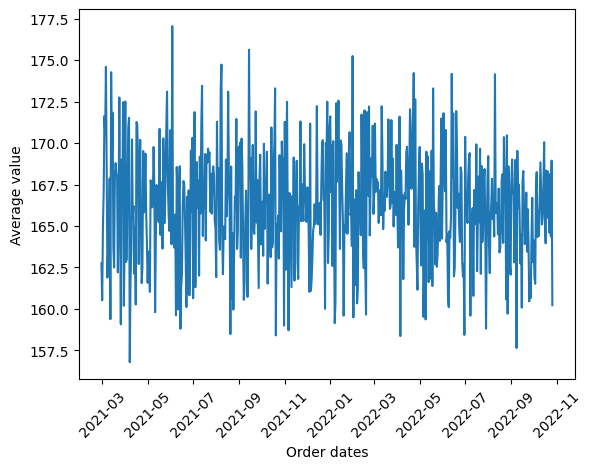

In [55]:
sns.lineplot(x="Order dates", y="Average value", data=avg_per_day)

plt.xticks(rotation=45)
plt.show()

As seen above, this is a fairly linear graph showing that the people still purchased items worth the same amount as they would during non-holiday periods

#### Group by day of week

In [61]:
day_of_week = avg_per_day.groupby(avg_per_day["Order dates"].dt.weekday).mean()
day_of_week.head(7)

,Average value
Order dates,
0,166.599303
1,165.802366
2,166.260718
3,166.575900
4,165.414207
5,166.880194
6,166.223453


<AxesSubplot:xlabel='Order dates'>

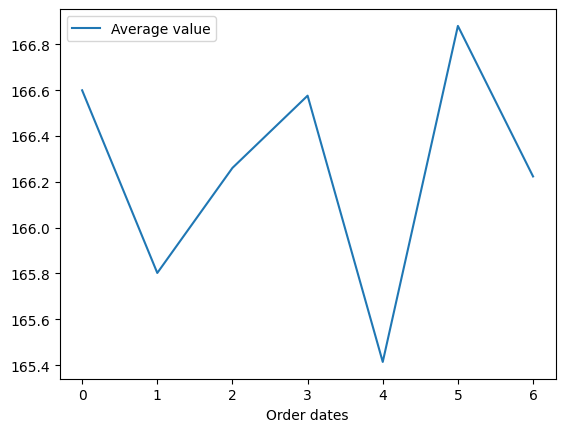

In [62]:
sns.lineplot(day_of_week)

Slight randomness with not that much difference between the days of the week